# Optimization under Uncertainty on the 3 Hump Camel Function

In [1]:
import sys
sys.path.insert(1, '../')

import numpy as np
from bayesopt import BayesianOptimization

from riskkernel import Normal_SEKernel
from surrogate import GaussianProcessRiskNeutral, GaussianProcessRegressor, CVaR
from sklearn.gaussian_process.kernels import WhiteKernel, ConstantKernel, RBF

from strategy import EIStrategy, SRBFStrategy, RandomStrategy
from experimental_design import SymmetricLatinHypercube as SLHC
import matplotlib.pyplot as plt

In [2]:
"""3 Hump Camel Function 2-Dimensional
Global Minima at (0,0) f(0) = 0.
Two local minima.
Box is [-5,5]^2
On this interval max is approximately 2000
"""
f_max = 2000.0
f = lambda x: (2*x[0]**2 - 1.05*x[0]**4 + x[0]**6/6 + x[0]*x[1] + x[1]**2)/f_max

# just for plotting...easier to evaluate with meshgrid
g = lambda x,y: (2*x**2 - 1.05*x**4 + x**6/6 + x*y + y**2)/f_max

# dimension
dim        = 2

# make sure minima are in the feasible region
lb         = -5*np.ones(dim)
ub         = 5.0*np.ones(dim)

# maximum evaluations
max_evals  = 300

# uncertainty variance
var    = 0.1

No handles with labels found to put in legend.


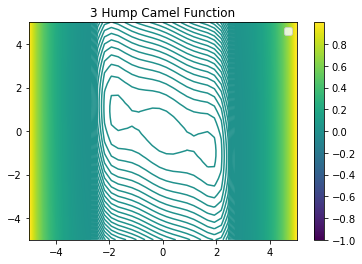

In [12]:
# plot the function
Ntest = 40
x = np.linspace(lb[0],ub[0],Ntest)
y = np.linspace(lb[1],ub[1],Ntest)
xx,yy = np.meshgrid(x,y)
Z   = g(xx,yy)
plt.contour(xx,yy,Z,np.linspace(-1,1,2000))
plt.colorbar()

# plot the optimum
#plt.scatter(xopt[0],xopt[1],color='r',s=150, marker=(5,1),label='Risk Neutral Optimum')

plt.title('3 Hump Camel Function')
plt.legend()
plt.show()

In [3]:
# experimental design
initial_num_pts    = 295 # initial evaluations
exp_design = SLHC(dim, initial_num_pts)

# strategy
strategy   = SRBFStrategy(lb,ub)

# uncertainty covariance
K      = var*np.eye(dim)

# risk-neutral GP kernel
kernel     = Normal_SEKernel(K)
surrogate  = GaussianProcessRiskNeutral(kernel)

# initialize surrogate
#kernel = ConstantKernel(1, (1e-3, 1e4)) * RBF(1, (0.001, 100)) + \
          #WhiteKernel(1e-3, (1e-6, 1e-2))
#surrogate = GaussianProcessRegressor(kernel =kernel)


# initialize the problem
problem    = BayesianOptimization(f,dim, max_evals, exp_design, strategy, surrogate,lb, ub)

# solve the problem
xopt,fopt  = problem.minimize()

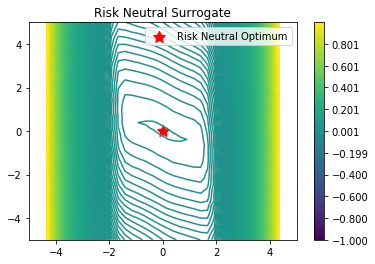

In [13]:
# plot the surrogate
X_grid = np.c_[ np.ravel(xx), np.ravel(yy) ]
z = surrogate.predict(X_grid)
z = z.reshape(xx.shape)

plt.contour(xx,yy,z,np.linspace(-1,1,1500))
plt.colorbar()

# plot the optimum
plt.scatter(xopt[0],xopt[1],color='r',s=150, marker=(5,1),label='Risk Neutral Optimum')
plt.legend()
plt.title('Risk Neutral Surrogate')
plt.show()

In [7]:
#uncertainty information 
mu         = 0.0
sigma      = np.sqrt(var)
p = lambda num_pts: np.random.normal(mu, sigma, (num_pts,dim))

# Monte Carlo parameters
num_points_MC = 10000

# beta weighting
beta = 0.95

# experimental design
initial_num_pts    = 295 # initial evaluations
exp_design = SLHC(dim, initial_num_pts)

# strategy
strategy   = SRBFStrategy(lb,ub)

# surrogate
kernel = ConstantKernel(1, (1e-3, 1e4)) * RBF(1, (0.001, 100)) + \
    WhiteKernel(1e-3, (1e-6, 1e-2))
surrogate = CVaR(kernel, p, beta, num_points_MC)

# initialize the problem
problem    = BayesianOptimization(f,dim, max_evals, exp_design, strategy, surrogate,lb, ub)

# solve the problem
xopt,fopt  = problem.minimize()

/home/padidar/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.46490002e+00,  3.09283473e-03,  1.16779549e+02]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 78, 'nit': 15, 'warnflag': 2}
  ConvergenceWarning)
/home/padidar/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.46716595e+00,  3.08264699e-03,  1.17276794e+02]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 64, 'nit': 16, 'warnflag': 2}
  ConvergenceWarning)
/home/padidar/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.47238731e+00,  1.26087712e-03,  1.17768738e+02]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 62, 'nit': 15, 'warnflag': 2}
  Conver

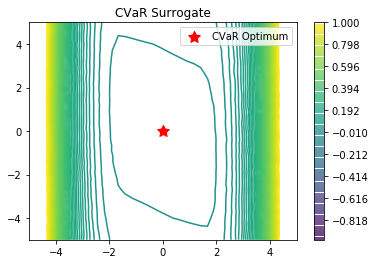

In [8]:
# plot the surrogate
X_grid = np.c_[ np.ravel(xx), np.ravel(yy) ]
z = surrogate.predict(X_grid)
z = z.reshape(xx.shape)

plt.contour(xx,yy,z,np.linspace(-1,1,100))
plt.colorbar()

# plot the optimum
plt.scatter(xopt[0],xopt[1],color='r',s=150, marker=(5,1),label='CVaR Optimum')
plt.legend()
plt.title('CVaR Surrogate')
plt.show()